# An Overview of Simple Path Loss and 11p Range

In [2]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

sns.set_theme(style='whitegrid')

In [3]:
def simple_path_loss(wavelength, distance, alpha):
    return (wavelength  / (4 * np.pi * distance)) ** 2

In [4]:
def to_wavelength(frequency):
    """Return wavelength in meters for frequency in Hz"""
    return 299792458.0 / frequency

In [5]:
def mW2dBm(mW):
    """Milli-Watt to dBm"""
    return 10 * np.log10(mW)

def dBm2mW(dBm):
    """dBm to Milli-Watt"""
    return 10 ** (dBm / 10)

assert all(math.isclose(mW, dBm2mW(mW2dBm(mW))) for mW in [20, 200, 2000, 20000])

## Pure Free Space Path Loss

In [6]:
center_frequency = 5.89e9  # 5.89 GHz, center frequency of the IEEE 801.11p control channel
alpha = 2.0
max_distance = 5000.0

[None]

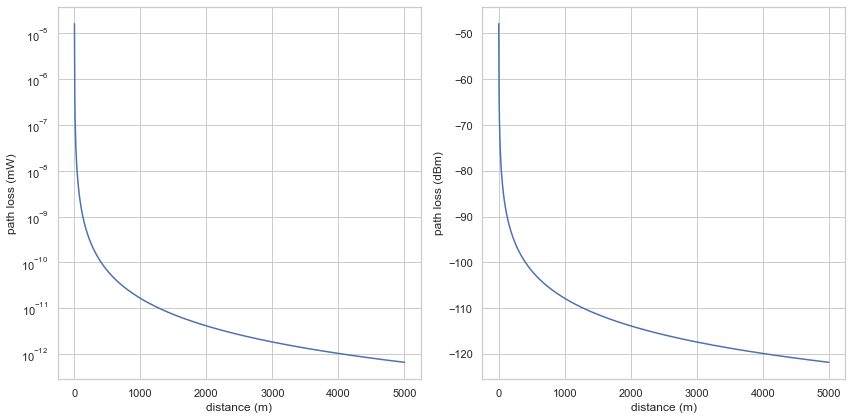

In [7]:
distances = pd.Series(np.linspace(1, max_distance, 1000), name="distance (m)")
path_loss_mW = pd.Series(simple_path_loss(to_wavelength(center_frequency), distances, alpha), name="path loss (mW)")
path_loss_dBm = pd.Series(mW2dBm(path_loss_mW), name="path loss (dBm)")

fig, (left, right) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 6))
sns.lineplot(x=distances, y=path_loss_mW, ax=left)
sns.lineplot(x=distances, y=path_loss_dBm, ax=right)
left.set(yscale="log")

## With transceiver config

In [28]:
minPowerLevel_dBm = -98
noiseLevel_dBm = -98

transmit_powers_mW = [20, 100, 200]

def snr(signal_mW):
    return signal_mW / dBm2mW(noiseLevel_dBm)

In [29]:
mW2dBm(pd.Series(transmit_powers_mW, index=transmit_powers_mW))

20     13.0103
100    20.0000
200    23.0103
dtype: float64

In [30]:
rss = pd.DataFrame({
    f"{transmit_power_mW} mW": mW2dBm(transmit_power_mW * path_loss_mW)
    for transmit_power_mW in transmit_powers_mW
}).set_index(distances)

[None]

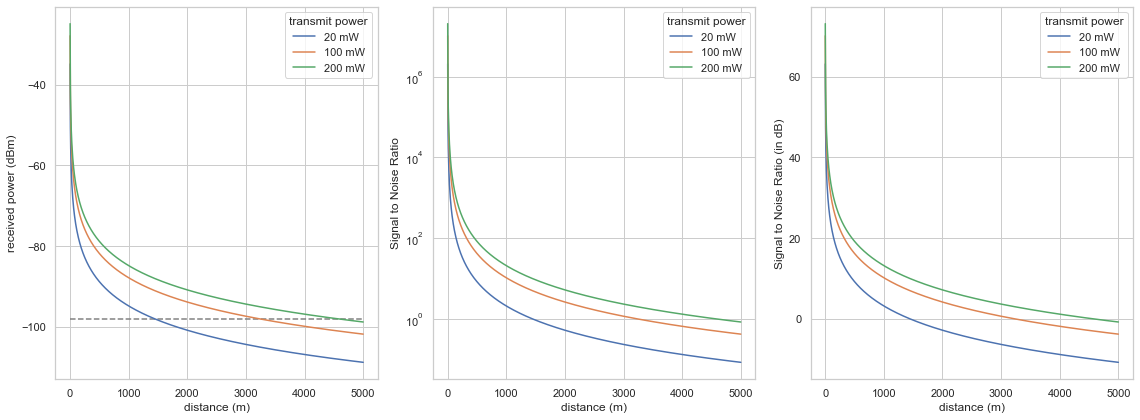

In [31]:
fig, (left, mid, right) = plt.subplots(1, 3, figsize=(16, 6), tight_layout=True)
sns.lineplot(
    data=rss.reset_index().melt(id_vars="distance (m)", var_name="transmit power", value_name="received power (dBm)"),
    y="received power (dBm)",
    x="distance (m)",
    hue="transmit power",
    ax=left,
)
sns.lineplot(
    data=rss.pipe(dBm2mW).pipe(snr).reset_index().melt(id_vars="distance (m)", var_name="transmit power", value_name="Signal to Noise Ratio"),
    y="Signal to Noise Ratio",
    x="distance (m)",
    hue="transmit power",
    ax=mid,
)
sns.lineplot(
    data=rss.pipe(dBm2mW).pipe(snr).pipe(mW2dBm).reset_index().melt(id_vars="distance (m)", var_name="transmit power", value_name="Signal to Noise Ratio (in dB)"),
    y="Signal to Noise Ratio (in dB)",
    x="distance (m)",
    hue="transmit power",
    ax=right,
)
left.hlines(y=[minPowerLevel_dBm], xmin=distances.iloc[0], xmax=distances.iloc[-1], colors=["grey"], linestyles=["dashed"])
mid.set(yscale="log")

# Decoding Probability

The above only considers the minimum power level for detectability.
For decodability (i.e., successfull reception), we need to consider the NIST error model as well.
This means also configuring a message length to account for bit errors.

Veins by default simulates 802.11p with 

* 6 Mbps bitrate
* 10 MHz bandwidth
* thus: OFDM QPSK R 1/2
* thus: 12 Mbps OFDM data rate
* thus: calling `NistErrorRate::getFecQpskBer` with `bValue` == 1

In my simulations, I use CAMs, which have a median length of 350 byte (2800 bit), see: c2ccc-2052.

In [33]:
bitrate = 6000000  # Bps
bandwidth_11p = 10000000  # Hz
phy_header_service_length = 16  # bits
phy_tail_length = 6  # bits
message_payload_length = 500 * 8  # bits

total_message_length = phy_header_service_length + message_payload_length + phy_tail_length

In [52]:
def nist_qpsk_ber(snr):
    return 0.5 * scipy.special.erfc(np.sqrt(snr / 2.0))

def calculate_pe(p, bValue):
    """Return the coded BER for the given p and b."""
    D = np.sqrt(4 * p * (1 - p))
    if bValue == 1:
        # code rate 1/2, use table 3.1.1
        return (
            36 * (D ** 10)
            + 211 * (D ** 12)
            + 1404 * (D ** 14)
            + 11633 * (D ** 16)
            + 77433 * (D ** 18)
            + 502690 * (D ** 20)
            + 3322763 * (D ** 22)
            + 21292910 * (D ** 24)
            + 134365911 * (D ** 26)
        )
    else:
        raise NotImplementedError("Only bValue == 1 is implemented right now.")

def nist_fec_qpsk_ber(snr, nbits, bValue=1):
    ber = nist_qpsk_ber(snr)
#     if ber == 0.0:
#         return 1.0
    pe = np.clip(calculate_pe(ber, bValue), a_min=0, a_max=1.0)
    return (1 - pe) ** nbits


<AxesSubplot:xlabel='distance (m)'>

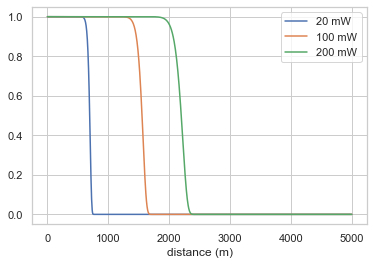

In [53]:
# plot packet error probablity for different SNRs
nist_fec_qpsk_ber(rss.pipe(dBm2mW).pipe(snr), total_message_length).plot()

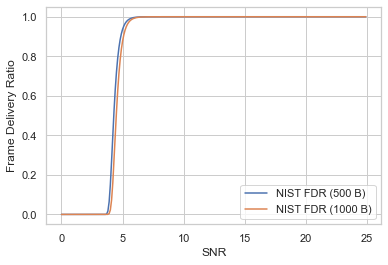

In [54]:
snr_sample_range = pd.Series(np.arange(0, 25, 0.1), name="SNR")
ax = pd.DataFrame({
    "SNR": snr_sample_range,
    "NIST FDR (500 B)": nist_fec_qpsk_ber(snr_sample_range, 500*8),
    "NIST FDR (1000 B)": nist_fec_qpsk_ber(snr_sample_range, 1000*8)
}).set_index("SNR").plot()
ax.set_ylabel("Frame Delivery Ratio")
None